# Ejercicio 1: Preparar el ambiente de trabajo

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import glob
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report
from sklearn.mixture import GaussianMixture

In [2]:
# Ruta absoluta del directorio actual
ruta_absoluta = os.getcwd()

# Lista de todos los archivos CSV en el directorio
lista_archivos_csv = glob.glob(os.path.join(ruta_absoluta, "dump", "*.csv"))

# Lista de dataFrames, uno por cada archivo csv
lista_dataframes = [pd.read_csv(archivo_csv) for archivo_csv in lista_archivos_csv]

# Concatenación de dataframes
df = pd.concat(lista_dataframes, ignore_index=True).drop('Unnamed: 0', axis=1)

# Renombrar columnas
df.columns = ['Artist', 'Genre', 'Song', 'Lyrics']

In [3]:
df.head(3)

,Artist,Genre,Song,Lyrics
0,Anthrax,metal,Deathrider,"Riding hard, high in the saddle \n Winged stee..."
1,Anthrax,metal,Metal Thrashing Mad,Racing down the road \n In a street machine of...
2,Anthrax,metal,I'm Eighteen,Lines form on my face and hands \n Lines form ...


In [4]:
df.shape

(9489, 4)

In [5]:
df.Genre.unique()

array(['metal', 'hiphop', 'rock', 'pop'], dtype=object)

# Ejercicio 2: Matriz de ocurrencias

In [6]:
# from sklearn.feature_extraction.text import CountVectorizer

# instanciamos un objeto
count_vectorizer = CountVectorizer(stop_words='english', max_features = 5000)

# Implementamos los pasos fit y transform
count_vectorizer_fit_transform = count_vectorizer.fit_transform(df.Lyrics)

# Extraemos tokens (palabras)
words = count_vectorizer.get_feature_names_out() # ordena en orden alfabético las palabras únicas

# extraemos frecuencia
words_freq = count_vectorizer_fit_transform.toarray().sum(axis=0)

# palabras a dataframe
words_freq_df = pd.DataFrame([list(words), list(words_freq)]).T

In [7]:
words_freq_df.columns = ['words', 'freq']
words_freq_df = words_freq_df.sort_values(by='freq', ascending=False)

In [8]:
words_freq_df

,words,freq
2483,like,19629
1241,don,17398
2362,know,14962
1847,got,14171
2299,just,13978
...,...,...
3375,ra,31
2666,mattress,31
3796,shakes,31
2646,martyr,31


# Ejercicio 3: Entrenamiento del Modelo

In [9]:
# from sklearn.decomposition import LatentDirichletAllocation
# from sklearn.model_selection import GridSearchCV

lda = LatentDirichletAllocation(learning_method='online', n_jobs=-1) # learning_method='online' es la ideal para mucho texto
grid = {'n_components': [5, 10, 15],
        'learning_decay': [0.7, 0.5]}

grid_search_lda = GridSearchCV(lda, param_grid=grid)

In [10]:
grid_search_lda.fit(count_vectorizer_fit_transform)

GridSearchCV(estimator=LatentDirichletAllocation(learning_method='online',
                                                 n_jobs=-1),
             param_grid={'learning_decay': [0.7, 0.5],
                         'n_components': [5, 10, 15]})

In [11]:
print("Best parameters:", grid_search_lda.best_params_)
print("Best score:", grid_search_lda.best_score_)

Best parameters: {'learning_decay': 0.5, 'n_components': 5}
Best score: -1851794.382615023


# Ejercicio 4 : Inferencia e Identificación de Tópicos

    En base a la mejor combinación de hiper parámetros, entrene el modelo con la matriz de atributos de las letras.

In [12]:
# modelo LDA con los mejores hiperparámetros 
# (n_components=5, learning_decay=0.5)

best_lda = grid_search_lda.best_estimator_
best_lda

LatentDirichletAllocation(learning_decay=0.5, learning_method='online',
                          n_components=5, n_jobs=-1)

In [13]:
best_lda.components_

array([[  0.20203013,   0.20213566,   0.21091341, ...,   0.20956383,
          0.20483178,   0.20168004],
       [  7.23776479, 107.8077147 ,  65.38501304, ...,  31.59587918,
         28.08602685,  19.52837164],
       [  0.20552181,   0.20207828,   0.20836018, ...,  12.1942644 ,
          0.20143343,   0.20352087],
       [ 20.06154623,   0.20159847,   0.20956892, ...,   0.20973828,
          0.20349273,   0.20170537],
       [  0.20394691,   0.2030674 ,   0.20492875, ...,   0.20514909,
          0.20515333,   0.2020074 ]])

In [14]:
# cantidad de tópicos
len(best_lda.components_)

5

In [15]:
# Cantidad de elementos en el tópico 1, cada tópico tiene 5000 palabras
len(best_lda.components_[0])

5000

In [16]:
best_lda.components_[0][:15]

array([ 0.20203013,  0.20213566,  0.21091341,  0.20744932,  0.73888366,
        1.85878276,  0.75442831, 27.38850387,  0.20457403, 41.27289749,
        0.20462627,  0.20444689,  0.21297439,  0.20042079,  0.20133032])

In [17]:
# mediante .components_ podemos extraer una matriz que entrega las distribución de palabras por cada tópico.
for topic_id, topic_name in enumerate(best_lda.components_):
    # para cada tópico
    print("tópico: {}".format(topic_id + 1))
    # mediante argsort logramos ordenar los elementos por magnitud.
    # para los elementos más relevantes ordenados por argsort, buscamos su correlativo en la matriz dispersa y devolvemos el nombre.
    # finalmente concatenamos las palabras
    print(" ".join([count_vectorizer.get_feature_names()[i] for i in topic_name.argsort()[:-15 - 1: -1]]))

tópico: 1
oh yeah hey come ooh ah let rock everybody baby got ha dance whoa gonna
tópico: 2
like got shit ain yo man nigga don fuck em know cause niggas ya just
tópico: 3
don love know just want say got baby wanna cause need gonna girl make like
tópico: 4
ll time away ve way life like just day night world heart feel know eyes
tópico: 5
god die death dead blood life soul war black song future kill hell power moment


### Comente a qué tópicos está asociada cada clase inferida.

    Considerando que para cada tópico aparecen las palabras más influyentes, los géneros correspondientes serían los siguientes:
        Tópico 1 : 'rock'
        Tópico 2 : 'metal'
        Tópico 3 : 'rock'
        Tópico 4 : 'rock'
        Tópico 5 : 'hiphop'

        Para esto se utilizaron las 100 palabras más usadas por cada género, obtenidas en el desafío guiado anterior.

# Ejercicio 5: Identificación de probabilidades

In [39]:
# generamos una transformación de los datos a distribución de tópico porpalabra en el documento
fit_best_lda = best_lda.transform(count_vectorizer_fit_transform)

# esta transformación la podemos coaccionar a un dataframe de la siguiente manera
topics_for_each_doc = pd.DataFrame(np.round(fit_best_lda, 3), index=df['Lyrics'].index)

#agregamos identificadores de columna
topics_for_each_doc.columns = list(map(lambda x: "T: {}".format(x), range(1, best_lda.n_components + 1)))

# concatenamos las probabilidades de tópico por documento a nuestra matriz original
concatenated_df = pd.concat([df['Lyrics'], topics_for_each_doc], axis=1)

# argmax en la matriz de tópicos
concatenated_df['highest_topic'] = np.argmax(topics_for_each_doc.values, axis=1) + 1

In [40]:
topics_for_each_doc.head(3)

,T: 1,T: 2,T: 3,T: 4,T: 5
0,0.006,0.006,0.006,0.497,0.486
1,0.159,0.151,0.005,0.319,0.365
2,0.072,0.510,0.242,0.141,0.034


In [41]:
concatenated_df.head(3)

,Lyrics,T: 1,T: 2,T: 3,T: 4,T: 5,highest_topic
0,"Riding hard, high in the saddle \n Winged stee...",0.006,0.006,0.006,0.497,0.486,4
1,Racing down the road \n In a street machine of...,0.159,0.151,0.005,0.319,0.365,5
2,Lines form on my face and hands \n Lines form ...,0.072,0.510,0.242,0.141,0.034,2


### Genere una matriz de correlaciones entre la probabilidad de tópicos inferidos. Comente brevemente cuales son las principales asociaciones existentes.

In [42]:
corr_matrix = topics_for_each_doc.corr()
corr_matrix

,T: 1,T: 2,T: 3,T: 4,T: 5
T: 1,1.000000,-0.127950,0.055985,-0.161513,-0.222805
T: 2,-0.127950,1.000000,-0.291384,-0.520345,-0.306422
T: 3,0.055985,-0.291384,1.000000,-0.209764,-0.400672
T: 4,-0.161513,-0.520345,-0.209764,1.000000,-0.148181
T: 5,-0.222805,-0.306422,-0.400672,-0.148181,1.000000


<AxesSubplot:>

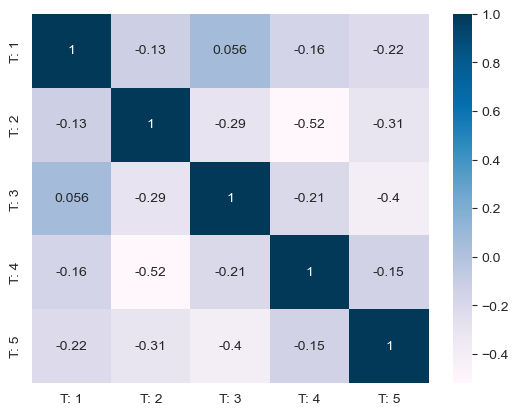

In [43]:
sns.heatmap(corr_matrix, annot=True, cmap='PuBu')

    Se observa que la mayoría de las correlaciones son negativas.
    Los tópicos que presentan una mayor magnitud en su correlación son los pares T4-T5 y T1-T5. Esto sugiere que los temas tratados en las dos variables son diferentes, lo que concuerda con lo analizado en el ejercicio 4 donde se concluyó que los tópicos T1 y T4 eran del género 'rock' y el tópico T5 era 'hiphop'.

### Con esta nueva base de datos, identifique las probabilidades de pertenencia para un artista específico.

In [44]:
df_topics = pd.concat([df[['Artist', 'Genre', 'Song']], concatenated_df], axis=1)
df_topics

,Artist,Genre,Song,Lyrics,T: 1,T: 2,T: 3,T: 4,T: 5,highest_topic
0,Anthrax,metal,Deathrider,"Riding hard, high in the saddle \n Winged stee...",0.006,0.006,0.006,0.497,0.486,4
1,Anthrax,metal,Metal Thrashing Mad,Racing down the road \n In a street machine of...,0.159,0.151,0.005,0.319,0.365,5
2,Anthrax,metal,I'm Eighteen,Lines form on my face and hands \n Lines form ...,0.072,0.510,0.242,0.141,0.034,2
3,Anthrax,metal,Panic,Move it to the front \n Reaching for the light...,0.319,0.117,0.003,0.383,0.178,4
4,Anthrax,metal,Subjugator,Out in the streets \n We're fighting tonight \...,0.043,0.047,0.003,0.506,0.401,4
...,...,...,...,...,...,...,...,...,...,...
9484,Weezer,rock,"Thief, You've Taken All That Was Me","Thief, of silent dreams \n Of golden scenes \n...",0.003,0.003,0.003,0.988,0.003,4
9485,Weezer,rock,We Are All In Love,When your out with your friends \n In your new...,0.136,0.076,0.714,0.072,0.003,3
9486,Weezer,rock,We Go Together,We go together \n And that's to stay \n And in...,0.037,0.005,0.005,0.831,0.122,4
9487,Weezer,rock,What Is This I Find?,[Jonas]: \n What is this I find? \n [Wuan]: \n...,0.128,0.428,0.222,0.212,0.010,2


In [45]:
def fetch_mixture(df, artist):
    return df[df['Artist'] == artist].loc[:, 'T: 1':'T: 5']

In [46]:
sia_df = fetch_mixture(df_topics, 'SIA')

In [50]:
sia_df.columns = ['Genero_musical_1', 'Genero_musical_2', 'Genero_musical_3', 'Genero_musical_4', 'Genero_musical_5']

In [51]:
sia_df.apply(np.mean, axis=0).sort_values()

Genero_musical_2    0.045396
Genero_musical_1    0.087523
Genero_musical_5    0.088270
Genero_musical_3    0.276324
Genero_musical_4    0.502676
dtype: float64

### Grafique la distribución de las probabilidades para algún artista en específico

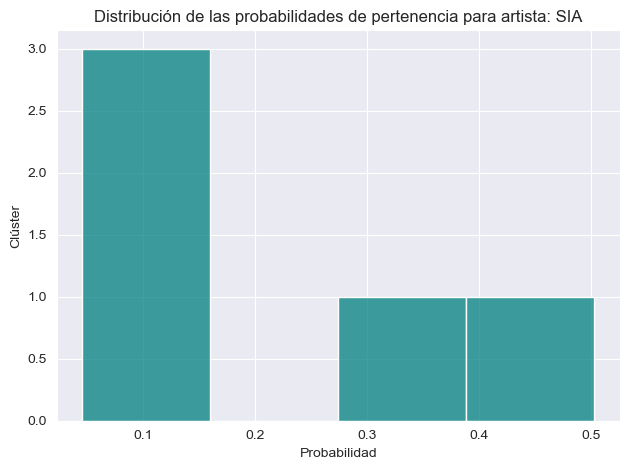

In [60]:
sns.histplot(sia_df.apply(np.mean, axis=0).sort_values(), color='teal')
plt.xlabel('Probabilidad')
plt.ylabel('Clúster')
plt.title(f'Distribución de las probabilidades de pertenencia para artista: SIA')
plt.tight_layout()
plt.show()